In [1]:
import pandas as pd
import numpy as np
from plprob.utils import (split_actuals_hist_future, split_forecasts_hist_future)
from plprob.predictor import ConPlPredictor
import matplotlib.pyplot as plt
from math import ceil

### Load data

In [2]:
seed = 1234
midatl_actual_df = pd.read_csv('../data/PJM/MIDATL_ACT.csv', parse_dates=['Time'], index_col='Time')
midatl_forecast_df = pd.read_csv('../data/PJM/MIDATL_FCST.csv', parse_dates=['Issue_time', 'Forecast_time'])

ps_actual_df = pd.read_csv('../data/PJM/PS_ACT.csv', parse_dates=['Time'], index_col='Time')

In [3]:
cp_probs = dict()
intraday_probs = dict()
daily_peaks = dict()
new_cp_days = []

num_of_cps = 1
hist_cps = []

for day in pd.date_range(start='2023-06-01', periods=122, freq='D'):
    
    start_date = day.strftime('%Y-%m-%d')

    print(start_date)
    
    start_time = pd.to_datetime(start_date).tz_localize('US/Eastern')
    timesteps = pd.date_range(start=start_time, periods=24, freq='h')

    # Separate historical and future data
    (midatl_load_actual_hists,
         midatl_load_actual_futures) = split_actuals_hist_future(
                midatl_actual_df, timesteps)
    
    (midatl_load_forecast_hists,
         midatl_load_forecast_futures) = split_forecasts_hist_future(
                midatl_forecast_df, timesteps)

    (ps_load_actual_hists,
         ps_load_actual_futures) = split_actuals_hist_future(
                ps_actual_df, timesteps)
    
    # Fit model and compute probability
    
    cond_predictor = ConPlPredictor(ps_load_actual_hists, midatl_load_actual_hists, 
                               midatl_load_forecast_hists, start_time, 
                               num_of_cps, hist_cps, forecast_lead_time_in_hour=1, seed=seed)
    cond_predictor.fit_model(0.05)
    cond_predictor.create_scenario(1000, midatl_load_forecast_futures)
    cond_predictor.fit_generate_cond_scenario(0.05, 1000)
    
    cond_predictor.compute_cp_probs()

    # Update historical CPs
    today_peak = ps_load_actual_futures.loc[timesteps, 'PS'].max()
    cond_predictor.update_cp(today_peak)
    if hist_cps != cond_predictor.hist_cps:
        new_cp_days.append(start_date)
        hist_cps = cond_predictor.hist_cps

    # Save CP and hour probability
    cp_probs[start_date] = cond_predictor.cp_prob
    n = 0
    while n < num_of_cps + 1:
        if n not in cp_probs[start_date]:
            cp_probs[start_date][n] = cp_probs[start_date][n-1]
        n += 1

    daily_peaks[start_date] = today_peak
    intraday_probs[start_date] = cond_predictor.peak_hour_prob
    

2023-06-01


/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014601881649802806, tolerance: 0.003797941025849587
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-06-02


/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014564083306872533, tolerance: 0.0037969304718675767
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-03


/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014559146554539382, tolerance: 0.0037965004447638347
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-04


/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.961e-03
  warnings.warn(
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012601964476559147, tolerance:

2023-06-05


/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016224006477834507, tolerance: 0.0037990411869400775
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-06


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016210141606997297, tolerance: 0.0037991976207473787
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-07


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016222460349382573, tolerance: 0.0037994507054931862
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-08


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013567784673227834, tolerance: 0.0038069065861756025
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-09


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013588568676645707, tolerance: 0.0038094242276563565
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-10


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013652241355011085, tolerance: 0.003814741399131865
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-06-11


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013656695413786224, tolerance: 0.0038135130261378837
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-12


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01259878445922169, tolerance: 0.003800008968088852
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did 

2023-06-13


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012572729025919216, tolerance: 0.0038002635308801483
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-14


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012601029033177724, tolerance: 0.0038006170119902496
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-15


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012645665672089024, tolerance: 0.0038008024036544625
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-16


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01267659774865848, tolerance: 0.003800848941611448
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did 

2023-06-17


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012708187105495483, tolerance: 0.003800948603929573
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-06-18


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01272386302073869, tolerance: 0.003801368231148314
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did 

2023-06-19


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011816304818175638, tolerance: 0.0038006286254883637
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-20


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.570e-03
  warnings.warn(
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0118168517778372, tolerance: 0

2023-06-21


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011831804964607784, tolerance: 0.003801064594226597
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-06-22


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011809795461338979, tolerance: 0.003801037781128458
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-06-23


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011844546927136435, tolerance: 0.0038012107046648063
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-24


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011882970946956561, tolerance: 0.0038015201763576933
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-25


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015417005085183177, tolerance: 0.00380480791356052
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did 

2023-06-26


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015416988495395856, tolerance: 0.003804877504969691
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-06-27


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015420260996712898, tolerance: 0.003804941340795532
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-06-28


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037315867767730992, tolerance: 0.0037214451432027243
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective d

2023-06-29


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037421477328862807, tolerance: 0.003721819648071072
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-06-30


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003761573569775578, tolerance: 0.003721841171244821
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-01


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037795169017371677, tolerance: 0.0037221376247684192
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective d

2023-07-02


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019768956322010922, tolerance: 0.0038099756238079083
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-07-03


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019624291709476438, tolerance: 0.0038087160835370507
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-07-04


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01960944273435672, tolerance: 0.0038093529264039234
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-05


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019833926494293053, tolerance: 0.0038089114350811216
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-07-06


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019963525219019118, tolerance: 0.0038085775390435637
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-07-07


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01998214670438614, tolerance: 0.0038096020718635195
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-08


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01969739802483872, tolerance: 0.003810575212578417
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did 

2023-07-09


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01805797170923995, tolerance: 0.0038038335453714823
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-10


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017987763133028523, tolerance: 0.0038033871940261438
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-07-11


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01797761059151526, tolerance: 0.0038032350189688645
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-12


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01801282509409674, tolerance: 0.003802535361181243
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did 

2023-07-13


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 8.837e-04
  warnings.warn(
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018233752357183164, tolerance:

2023-07-14


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018348857665486662, tolerance: 0.003803164041627431
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-15


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01666012679493889, tolerance: 0.0037977270997601696
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-16


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016626824137034646, tolerance: 0.00379781112958937
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did 

2023-07-17


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01661357741873104, tolerance: 0.003796863639427657
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did 

2023-07-18


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01669387510047926, tolerance: 0.0037971470837436048
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-19


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.225e-03
  warnings.warn(
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016706834286146943, tolerance:

2023-07-20


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01667080926308273, tolerance: 0.0037979682571412567
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-21


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016690629435046844, tolerance: 0.003798206089646432
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-22


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016756341543825215, tolerance: 0.00380067185560696
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did 

2023-07-23


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01678077023441915, tolerance: 0.0038007320983711843
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-24


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016733560247331525, tolerance: 0.0037986876886966755
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-07-25


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016751962983036606, tolerance: 0.003798534600701756
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-26


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -2.339e-03
  warnings.warn(
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016675263110613514, tolerance

2023-07-27


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016746338975742958, tolerance: 0.0037966023000514056
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-07-28


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01672737349675657, tolerance: 0.0037973945712510026
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-29


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022949409123569353, tolerance: 0.003797514778608251
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-07-30


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022888904955379985, tolerance: 0.0037979096864929392
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-07-31


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022892818236819323, tolerance: 0.0037973719165077208
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-01


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02289171925004041, tolerance: 0.003797363691033129
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did 

2023-08-02


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022909658593292193, tolerance: 0.0037977408100814767
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-03


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022921881836246882, tolerance: 0.0037981323664975884
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-04


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017084964051043983, tolerance: 0.003794246146582696
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-08-05


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01710690522452296, tolerance: 0.0037944925137520253
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-08-06


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017075173366535523, tolerance: 0.003794535509272379
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-08-07


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017050107554901217, tolerance: 0.0037936015324059754
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-08


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016977727162512224, tolerance: 0.003793456909205535
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-08-09


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016982941619758662, tolerance: 0.0037934353115802867
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-10


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016984773427971334, tolerance: 0.0037934149299321484
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-11


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015020795258877229, tolerance: 0.0037948582794016888
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-12


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015041470829267212, tolerance: 0.0037950241044162948
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-13


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.911e-03
  warnings.warn(
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015035143055463607, tolerance:

2023-08-14


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014974926006324552, tolerance: 0.0037943436076880847
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-15


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01498040188892702, tolerance: 0.0037944330825196134
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-08-16


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014974912268115759, tolerance: 0.0037943475956959305
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-17


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014987355277426673, tolerance: 0.00379445471415472
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did 

2023-08-18


/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004695315498068453, tolerance: 0.0038198991990424256
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-19


/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.015e-03
  warnings.warn(
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004719780533420703, tolerance:

2023-08-20


/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0047558025903313705, tolerance: 0.0038179383846071255
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective d

2023-08-21


/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004907124818487318, tolerance: 0.0038125465531840676
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-22


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.530e-03
  warnings.warn(
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005039199820423335, tolerance:

2023-08-23


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.158e-03
  warnings.warn(
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005036958803636082, tolerance

2023-08-24


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005061575330913115, tolerance: 0.0038133331753440964
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-25


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005086626489791968, tolerance: 0.0038130346998311326
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-26


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005019969515707601, tolerance: 0.0038130605652335805
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-27


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 3.239e-03
  warnings.warn(
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005005528919546975, tolerance:

2023-08-28


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.175e-03
  warnings.warn(
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005013107972487774, tolerance

2023-08-29


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005032800310964092, tolerance: 0.0038125779319643787
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-08-30


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0050145041242757316, tolerance: 0.0038126697983302807
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective d

2023-08-31


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005551435067943089, tolerance: 0.003802373226198785
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-09-01


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005565674597242776, tolerance: 0.0038026683493514167
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-02


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005567386952009201, tolerance: 0.0038031538790971485
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-03


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005568748964186909, tolerance: 0.00380236122895768
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did 

2023-09-04


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005551852247435818, tolerance: 0.0037999569904415952
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-05


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005564140292619868, tolerance: 0.0037986428946867813
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-06


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056137615735067925, tolerance: 0.0037992648235665723
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective d

2023-09-07


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007226576489067327, tolerance: 0.0038069242226836802
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-08


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007002096314010942, tolerance: 0.0038080832611602383
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-09


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006918781437477151, tolerance: 0.003806460056677034
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-09-10


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069255295054375665, tolerance: 0.0038058693631280033
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective d

2023-09-11


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006935286913773098, tolerance: 0.0038059888676069452
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-12


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006914706485950717, tolerance: 0.0038059374820296928
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-13


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00738336523586014, tolerance: 0.0038049138287632694
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-09-14


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007312264932089363, tolerance: 0.0038047167413542767
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-15


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007299799046926125, tolerance: 0.0038049431189949552
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-16


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007317491644528218, tolerance: 0.0038052517601843017
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-17


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007306984206309153, tolerance: 0.0038054870389740707
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-18


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007463635206470087, tolerance: 0.003801022644530615
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-09-19


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0074665613394060415, tolerance: 0.0038009920250945558
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective d

2023-09-20


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006851297357385988, tolerance: 0.0038050352481704005
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-21


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006863169681821546, tolerance: 0.0038053057001963546
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-22


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006897066500783922, tolerance: 0.0038056209313923933
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-23


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -5.178e-04
  warnings.warn(
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006891038738245925, tolerance

2023-09-24


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006884750106479487, tolerance: 0.0038033448004694643
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-25


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006049852360810348, tolerance: 0.0037983694498802253
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-26


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004396075922926457, tolerance: 0.003808922050106094
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-09-27


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004428348188739051, tolerance: 0.0038229928131958595
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective di

2023-09-28


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006990012546786772, tolerance: 0.003826435838589096
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-09-29


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007617531003702993, tolerance: 0.003824528972648272
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did

2023-09-30


/Users/as3993/Amit/PLProb/R/univariate.py:320: RuntimeWarning: invalid value encountered in power
  val[upper_tail_x] = 1 - (1 - p_upper) * (1 + (k * (x[upper_tail_x] - b))/a)**(-1/k)
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -5.082e-04
  warnings.warn(
/Users/as3993/Amit/PLProb/R/univariate.py:330: RuntimeWarning: invalid value encountered in power
  val[lower_tail_x] = p_lower * (1 - (k * (x[lower_tail_x] - b))/a)**(-1/k)
/Users/as3993/anaconda3/envs/plprob/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:139: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007858665317478142, tolerance

### Collect results

In [4]:
daily_peak_df = pd.DataFrame({'Time': pd.to_datetime(list(daily_peaks.keys())), 
                              'PS': daily_peaks.values()}).set_index('Time').resample('h').ffill()

/var/folders/p_/cgtqpk9j7kq74n_ft0y8yvxr0000gp/T/ipykernel_37680/4126058961.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'PS': daily_peaks.values()}).set_index('Time').resample('H').ffill()


In [5]:
cp_prob_dict = {'Time':pd.to_datetime(list(cp_probs.keys()))}

for n in range(num_of_cps):
    n_cp_prob = []
    for day, probs in cp_probs.items():
        n_cp_prob.append(probs[n])
    cp_prob_dict[n] = n_cp_prob
cp_prob_df = pd.DataFrame(cp_prob_dict).set_index('Time').resample('h').ffill()

/var/folders/p_/cgtqpk9j7kq74n_ft0y8yvxr0000gp/T/ipykernel_37680/2497321910.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  cp_prob_df = pd.DataFrame(cp_prob_dict).set_index('Time').resample('H').ffill()


/var/folders/p_/cgtqpk9j7kq74n_ft0y8yvxr0000gp/T/ipykernel_37680/3808061064.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  new_cp_hours = pd.to_datetime(new_cp_days) + pd.Timedelta(12,unit='H')


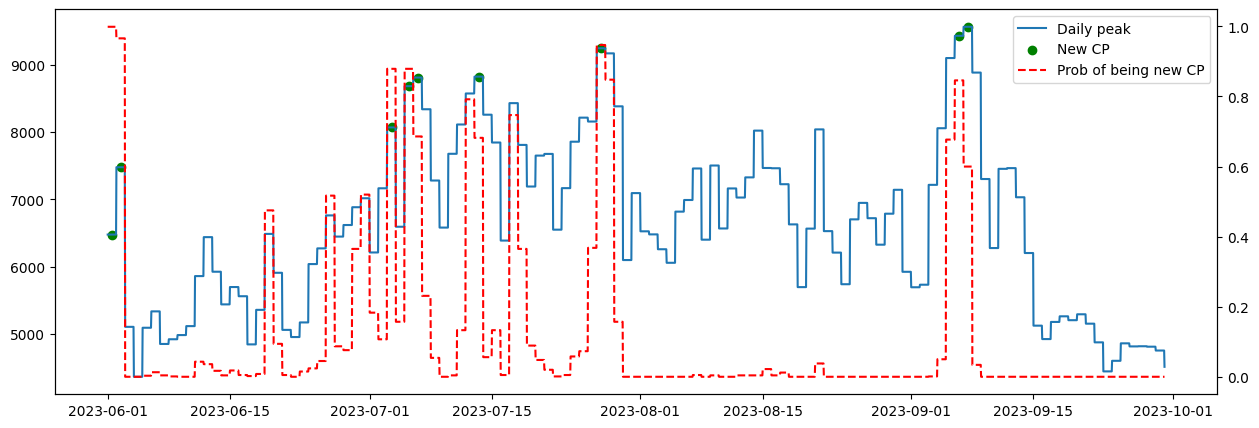

In [6]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(111)
ax.plot(daily_peak_df, label='Daily peak')

new_cp_hours = pd.to_datetime(new_cp_days) + pd.Timedelta(12,unit='H')
ax.scatter(new_cp_hours, 
              daily_peak_df.loc[new_cp_hours], color='green', label='New CP')

ax2 = ax.twinx()
ax2.plot(cp_prob_df[0], color='red', linestyle='dashed', label='Prob of being new CP')


h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc=1, prop={'size': 10})

/var/folders/p_/cgtqpk9j7kq74n_ft0y8yvxr0000gp/T/ipykernel_37680/3432523970.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timesteps = pd.date_range(start=day, periods=24, freq='H', tz='US/Eastern')


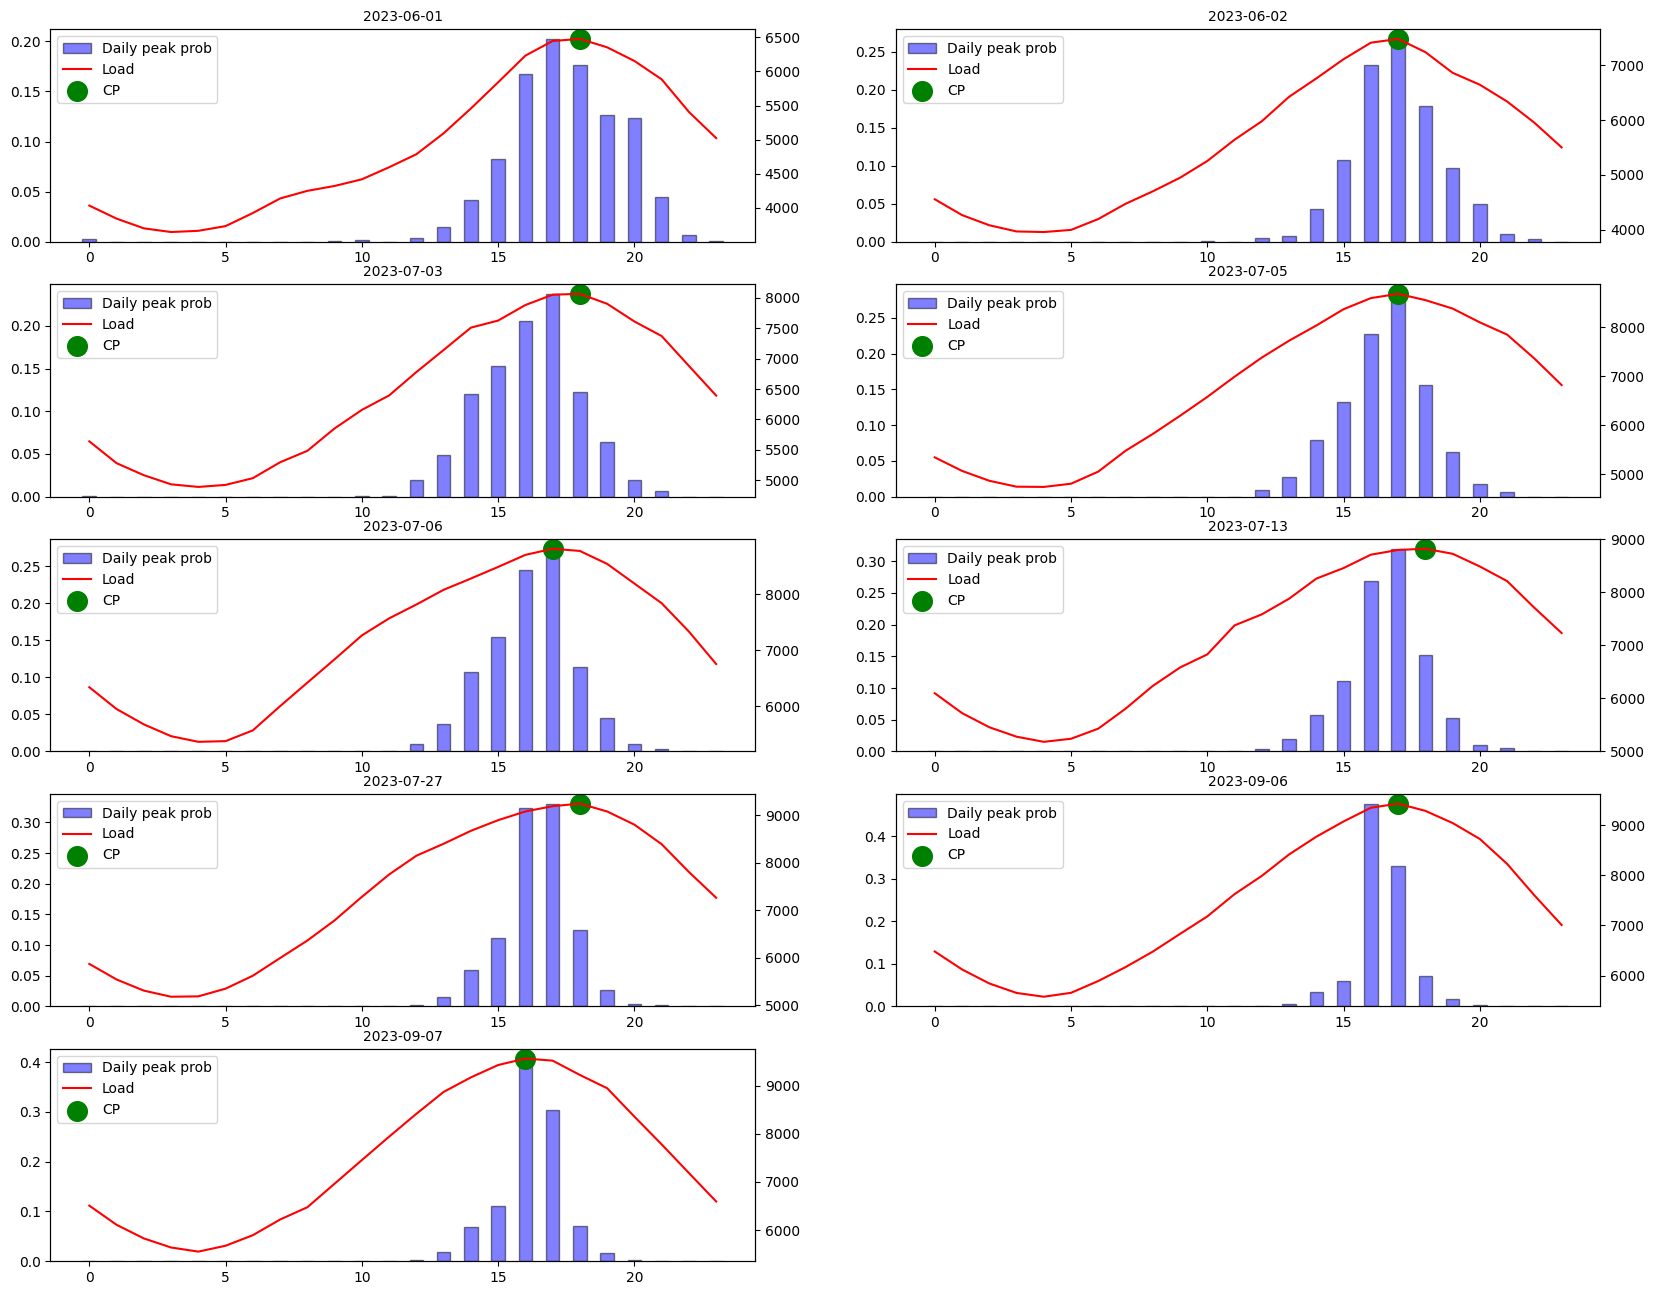

In [7]:
fig = plt.figure(figsize=(ceil(len(new_cp_days) / 2) * 4, 16))

for i, day in enumerate(new_cp_days):
    
    timesteps = pd.date_range(start=day, periods=24, freq='H', tz='US/Eastern')

    a_df = ps_actual_df.loc[timesteps]

    ax = fig.add_subplot(ceil(len(new_cp_days) / 2), 2, i + 1)

    probs = intraday_probs[day]
    p = [probs[t] if t in probs else 0 for t in timesteps]
    
    ax.bar(range(24), p, width=0.5, alpha=0.5,
           color='blue',edgecolor='black',label='Daily peak prob')


    ax2 = ax.twinx()
    ax2.plot(range(24), a_df,
             '-r', label='Load')
    ax2.scatter(a_df.idxmax().dt.hour, a_df.max(), c = 'green', marker='o', s=200, label='CP')
    
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc=2)
    

    ax.set_title(day, fontsize=10)
